# Actor-Critic

拓展部分

个人兴趣的一些探索

## 1 env & utils

In [41]:
import gym
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.optim import Adam
from torch.autograd import Variable
import matplotlib.pyplot as plt

torch.manual_seed(28)
%matplotlib inline

In [42]:
EPOCHS = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make("CartPole-v1")    # 0 up, 1 right, 2 down, 3 left
env.reset()
env.action_space.n

2

In [43]:
def move_avg(a,n=100,mode="valid"):	# 滑动平均
    return(np.convolve(a, np.ones((n,))/n, mode=mode))	
    
def plot_reward(model_name, rew): 
    plt.figure(figsize=[15, 6])
    
    plt.subplot(1,2,1)
    X = np.linspace(1,len(rew),len(rew))
    plt.plot(X, rew)
    plt.xlabel('epochs')
    plt.title(model_name)

    plt.subplot(1,2,2)
    rew = move_avg(rew)
    X = np.linspace(1,len(rew),len(rew))
    plt.plot(X, rew)
    plt.xlabel('epochs')
    plt.title(model_name)
    plt.show()

## 2 Algorithm

基于PolicyGradient，诞生了actor-critic。本质是结合了 Policy Gradient (Actor) 和 Function Approximation (Critic) 的方法。Actor 基于概率选行为, Critic 基于 Actor 的行为评判行为的得分, Actor 根据 Critic 的评分修改选行为的概率。

优势：可以单步更新，训练效率较Policygradient更快。

缺点：取决于 Critic 的价值判断, 但是 Critic 难收敛, 再加上 Actor 的更新, 就更难收敛.。

In [44]:
class AC_net(nn.Module):

    def __init__(self):
        super(AC_net, self).__init__()

        self.feature = nn.Sequential(
            nn.Linear(4, 10),
            )
        self.act_layer = nn.Sequential(
            nn.Linear(10, 2),
            nn.Softmax(dim=0)
            )
        self.val_layer = nn.Linear(10, 1)
    
    def forward(self, x):

        x = self.feature(x)    
        v = self.val_layer(x) # 估计当前的状态
        a_prob = self.act_layer(x)  # 获得依据当前状态的动作概率
        a_disb = Categorical(a_prob)    # 获得依据当前状态的动作概率分布
        a = a_disb.sample()             # 根据分布采样动作

        a_logprob = a_disb.log_prob(a)
        return v, a.item(), a_logprob

class ActorCritic:

    def __init__(self, learning_rate=0.01, reward_decay=0.99, device=torch.device('cuda')):

        self.gamma = reward_decay
        self.lr = learning_rate
        self.device = device
        self.net = AC_net().to(device)
        self.optimizer = Adam(self.net.parameters(), lr=self.lr)
        self.logprobs = []
        self.val_buf = []
        self.rew_buf = []

    def clear(self):
        self.logprobs = []
        self.val_buf = []
        self.rew_buf = []

    def add(self, val, act_log_prob, rew):
        self.val_buf.append(val)
        self.logprobs.append(act_log_prob)
        self.rew_buf.append(rew)

    def computeloss(self):

        # 计算衰减reward
        rewards = []
        dis_reward = 0
        for rew in self.rew_buf[::-1]:
            dis_reward = rew + self.gamma * dis_reward
            rewards.insert(0, dis_reward)
        
        # reward归一化
        rewards = torch.FloatTensor(rewards).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        # 计算loss
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.val_buf, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value[0], reward)
            loss += (action_loss + value_loss)   

        return loss
    
    def learn(self):

        self.optimizer.zero_grad()
        loss = self.computeloss()
        loss.backward()
        self.optimizer.step()
        self.clear()
        return loss.item()

In [45]:
agent = ActorCritic( device=device)

In [46]:
# train step
rew_total = []
for epoch in range(EPOCHS):
    obs = env.reset()
    done = False
    final_reward = 0
    while not done:
        
        # env.render()
        loss = 0
        v, a, a_logprob = agent.net(Variable(torch.FloatTensor(obs)).to(device))
        obs_next, reward, done, info = env.step(a)
        x, x_dot, theta, theta_dot = obs_next

        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        reward = r1 + r2
            
        agent.add(v, a_logprob, reward)
        final_reward += reward

        # 同PolicyGradient 回合结束后更新网络
        if done:
            loss = agent.learn()
            print('Ep: ', epoch,' | reward:%.3f'%final_reward, ' | loss:%.4f'%loss)

            rew_total.append(final_reward)
        
        obs = obs_next


Ep:  0  | reward:3.677  | loss:3.9843
Ep:  1  | reward:8.044  | loss:6.5016
Ep:  2  | reward:3.451  | loss:4.4562
Ep:  3  | reward:4.108  | loss:4.5285
Ep:  4  | reward:9.376  | loss:6.9549
Ep:  5  | reward:7.512  | loss:4.6346
Ep:  6  | reward:11.558  | loss:5.4649
Ep:  7  | reward:6.941  | loss:4.3494
Ep:  8  | reward:8.410  | loss:13.8645
Ep:  9  | reward:4.726  | loss:7.3285
Ep:  10  | reward:19.984  | loss:13.1852
Ep:  11  | reward:7.906  | loss:17.5759
Ep:  12  | reward:21.251  | loss:20.5536
Ep:  13  | reward:3.798  | loss:5.3749
Ep:  14  | reward:6.564  | loss:11.1946
Ep:  15  | reward:4.844  | loss:6.3920
Ep:  16  | reward:3.185  | loss:5.6635
Ep:  17  | reward:4.720  | loss:6.7375
Ep:  18  | reward:2.890  | loss:7.2489
Ep:  19  | reward:22.615  | loss:35.9065
Ep:  20  | reward:12.417  | loss:18.7527
Ep:  21  | reward:5.583  | loss:24.8140
Ep:  22  | reward:6.420  | loss:14.0265
Ep:  23  | reward:1.057  | loss:7.1373
Ep:  24  | reward:9.447  | loss:13.3204
Ep:  25  | reward:10

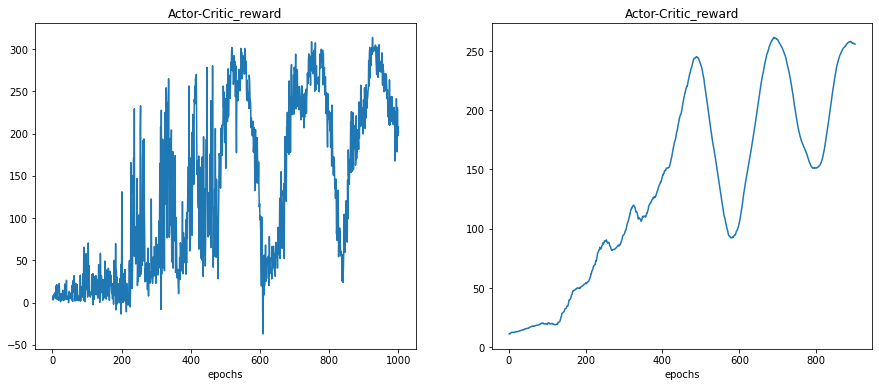

In [47]:
plot_reward('Actor-Critic_reward', rew_total)